In [1]:
%pip install torch torchvision
%pip install tqdm
%pip install ipywidgets
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Relevant torch imports, TQDM required for visualization
import os
import torch
import time
import copy
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import ParameterGrid


print("Package importing successful.")

Package importing successful.


# Training Configuration 

In [3]:
# Defining Dataset directory and transformation settings
model_dataset_dir = './images/'
model_batch_size = 32
model_num_workers = 2

# Training settings
model_num_epochs = 25
model_learning_rate = 0.005
model_momentum = 0.9
model_weight_decay=1e-4

# Scheduler settings
model_step_size = 7
model_gamma = 0.1

# Model settings
model_save_path = 'saved_models/final_model_weights_with.tar'

# Data transformations
# Using mean and standard deviation of imagenet for the normaalization.
model_data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
    'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
}

# Loading Dataset
We are using the PlantNet-300K dataset.
TODO: ADD FURTHER DETAILS

In [4]:
# Setting image dataset for training and validation
image_datasets = {
    data: ImageFolder(os.path.join(model_dataset_dir, data), model_data_transforms[data]) 
    for data in ['train', 'val']
}

In [5]:
# Identifying the classes with low image data
classes = np.array(image_datasets['train'].targets)
unique_classes, counts = np.unique(classes, return_counts=True)

# Calculate average samples per class
average_samples = np.mean(counts)
print(f"Average number of samples per class: {average_samples:.0f}")

# the class with the maximum and minimum samples
max_samples_index = np.argmax(counts)
min_samples_index = np.argmin(counts)

max_class_name = image_datasets['train'].classes[unique_classes[max_samples_index]]
min_class_name = image_datasets['train'].classes[unique_classes[min_samples_index]]

print(f"Class '{max_class_name}' has the highest number of samples: {counts[max_samples_index]}")
print(f"Class '{min_class_name}' has the lowest number of samples: {counts[min_samples_index]}")

Average number of samples per class: 226
Class '1363227' has the highest number of samples: 7208
Class '1355920' has the lowest number of samples: 2


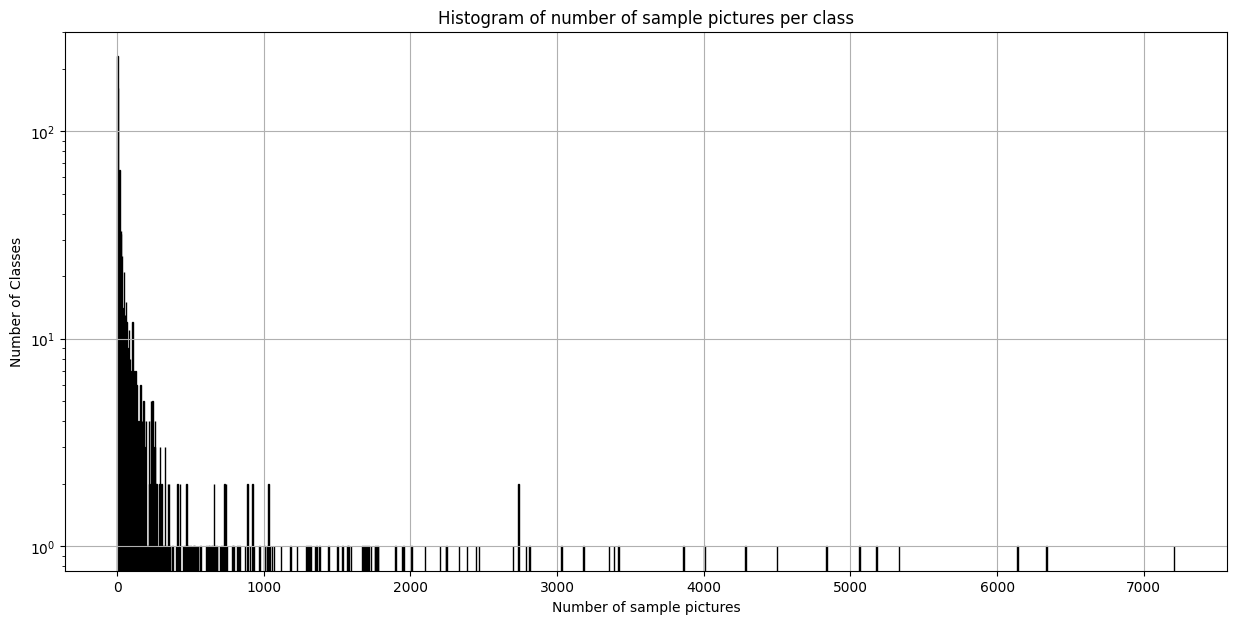

In [6]:
# Visualizing the distribution of images per class\
plt.figure(figsize=(15, 7))  # Adjust the figure size as necessary
plt.hist(counts, bins=2000, color='green', edgecolor='black', log=True)  
plt.title('Histogram of number of sample pictures per class')
plt.xlabel('Number of sample pictures')
plt.ylabel('Number of Classes')
plt.grid(True)
plt.show()

In [7]:
dataloaders = {
    data: DataLoader(image_datasets[data], batch_size=model_batch_size, shuffle=True, num_workers=model_num_workers) 
    for data in ['train', 'val']
}

In [8]:
# Model setup
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
number_of_features = model.fc.in_features # number of features in last layer
model.fc = nn.Linear(number_of_features, len(image_datasets['train'].classes)) # Replacing last layer with classes=no.of species


# Swithching to CUDA if possible
# Recommended to train the model faster, requires CUDA supported GPU
print("CUDA available: ",torch.cuda.is_available())
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA available:  True


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=model_learning_rate, weight_decay=model_weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=model_learning_rate, momentum=model_momentum, weight_decay=model_weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=model_step_size, gamma=model_gamma)

num_epochs =model_num_epochs


In [ ]:

# Initialize lists to store per epoch metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize the best validation accuracy
best_val_acc = 0.0
best_epoch = 0

# Ensure the directory exists or create it
model_dir = os.path.dirname(model_save_path)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for epoch in range(num_epochs):
    # Training Phase
    epoch_start = time.time()
    model.train()  
    train_running_corrects = 0
    train_running_loss = 0.0

    train_progress = tqdm(dataloaders['train'], desc=f'Training Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in train_progress:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)

    train_epoch_loss = train_running_loss / len(image_datasets['train'])
    train_epoch_acc = train_running_corrects.double() / len(image_datasets['train'])
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc.item())

    # Validation Phase
    model.eval()  
    val_running_corrects = 0
    val_running_loss = 0.0

    val_progress = tqdm(dataloaders['val'], desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch')
    for inputs, labels in val_progress:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(image_datasets['val'])
    val_epoch_acc = val_running_corrects.double() / len(image_datasets['val'])
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_epoch = epoch

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_epoch_loss,
            'accuracy': best_val_acc.item(),
        }, model_save_path)
        
    epoch_duration = time.time() - epoch_start

    # Print statistics for the current epoch
    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1] * 100:.2f}%, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1] * 100:.2f}%, '
          f'Time: {epoch_duration:.2f}s\n')

print(f"Best model was from epoch {best_epoch + 1} with validation accuracy of {best_val_acc:.4f}")


Training Epoch 1/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 1/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 1/25 - Train Loss: 4.6383, Train Acc: 12.25%, Val Loss: 4.0869, Val Acc: 19.25%, Time: 3077.35s



Training Epoch 2/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 2/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 2/25 - Train Loss: 4.0546, Train Acc: 19.58%, Val Loss: 3.8105, Val Acc: 24.38%, Time: 2743.56s



Training Epoch 3/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 3/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 3/25 - Train Loss: 3.8175, Train Acc: 22.89%, Val Loss: 3.5546, Val Acc: 27.66%, Time: 2978.25s



Training Epoch 4/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

Validation Epoch 4/25:   0%|          | 0/973 [00:00<?, ?batch/s]

Epoch 4/25 - Train Loss: 3.6985, Train Acc: 24.85%, Val Loss: 3.3825, Val Acc: 30.41%, Time: 2949.47s



Training Epoch 5/25:   0%|          | 0/7623 [00:00<?, ?batch/s]

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- **Model Architecture**: Pre-trained ResNet18
- **Batch Size**: 32
- **Number of Workers**: 4
- **Loss Function**: Cross-Entropy Loss
- **Optimizer**: SGD (Learning Rate: 0.001, Momentum: 0.9)
- **Learning Rate Scheduler**: StepLR (Step Size: 7, Gamma: 0.1)
- **Number of Epochs**: 25
- **Device**: CUDA (if available, otherwifor validationfor validation